# Reapply existing signatures

Simple example of fitting the provided example data to the 5 ES model

In [1]:
from cvanmf import models
import numpy as np

# The example data is quite large, so we'll take a subset of samples
result = models.five_es().reapply(
    y=models.example_abundance().iloc[:, :30]
)

result.model_fit.describe()

count    30.000000
mean      0.797735
std       0.185211
min       0.202620
25%       0.762472
50%       0.861932
75%       0.931031
max       0.974673
Name: model_fit, dtype: float64

<Figure size 100x100 with 0 Axes>

The results object is a Decomposition class object. The Enterosignature weights for each sample are in the H matrix of the results object.

In [2]:
result.h.head().iloc[:, :5]

,W2.35.ST,W1.41.ST,W2.42.ST,W1.39.ST,M1.61.ST
ES_Bact,1.088478e-03,0.000059,5.578098e-06,2.805688e-15,5.275954e-07
ES_Bifi,2.820760e-08,0.000581,2.067816e-03,6.448222e-03,9.760024e-05
ES_Esch,7.382280e-04,0.000032,1.588800e-02,1.233557e-03,4.232979e-03
ES_Prev,1.765843e-02,0.037969,3.054059e-02,2.867602e-02,3.459507e-02
ES_Firm,1.283633e-02,0.004180,3.084730e-15,5.049724e-03,3.604686e-03


We can get a scaled version of the H matrix (so each sample sums to 1), and visualise this using a mix of the inbuilt methods.

In [3]:
assert np.allclose(result.scaled('h').sum(), 1.0)
result.scaled('h').iloc[:, :5]

,W2.35.ST,W1.41.ST,W2.42.ST,W1.39.ST,M1.61.ST
ES_Bact,3.367661e-02,0.001369,1.150076e-04,6.775794e-14,0.000012
ES_Bifi,8.727195e-07,0.013567,4.263364e-02,1.557259e-01,0.002295
ES_Esch,2.284016e-02,0.000747,3.275742e-01,2.979066e-02,0.099527
ES_Prev,5.463371e-01,0.886704,6.296772e-01,6.925316e-01,0.813411
ES_Firm,3.971453e-01,0.097612,6.360008e-14,1.219519e-01,0.084755


The relative weights can be plotted as a stacked bar, using the `plot_relative_weight` method. By default, the top part of this plot shows the model fit of each sample (the cosine angle between the sample and X and in WH), with 1 being good and 0 bad. A default line of 0.4 for "poor model fit" is given, based on the Enterosignatures paper. Below this is a stacked bar plot, showing the relative abundance of each signature in each sample.

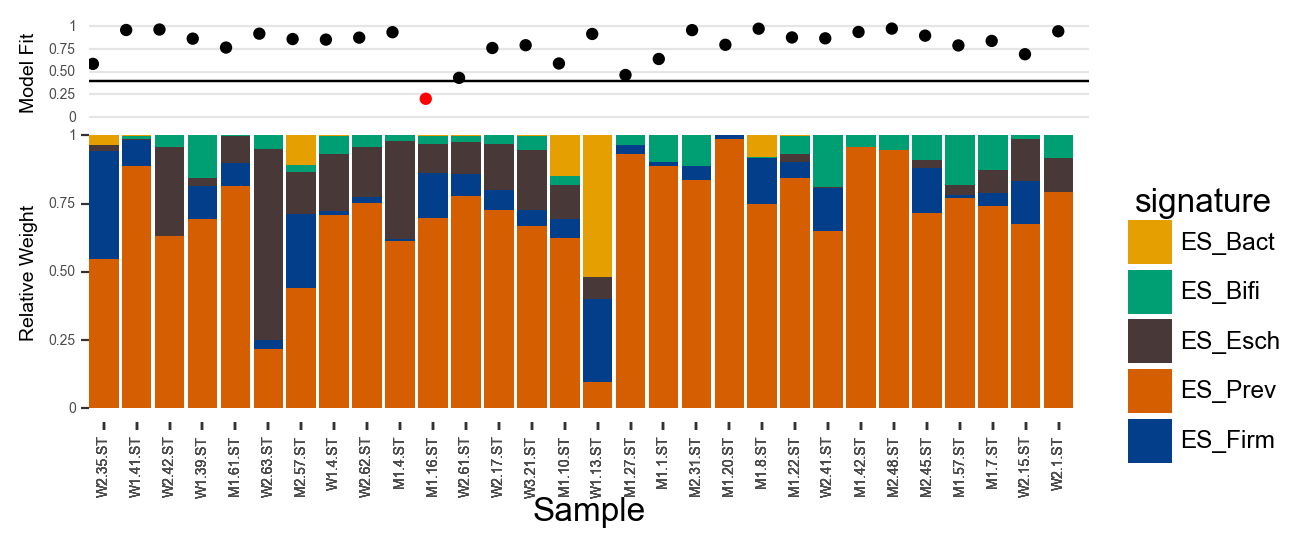

In [4]:
# The heights parameter controls the height in inches of each bit
result.plot_relative_weight(heights=[0.5, 1.5], width=5)

# De-novo signatures

We can attempt to discover signatures from new data. For these examples we will use a simple synthetic dataset with 4 signatures which slightly overlap.

In [5]:
import seaborn as sns
import pathlib
from cvanmf.denovo import rank_selection, plot_rank_selection, decompositions, Decomposition

<Axes: >

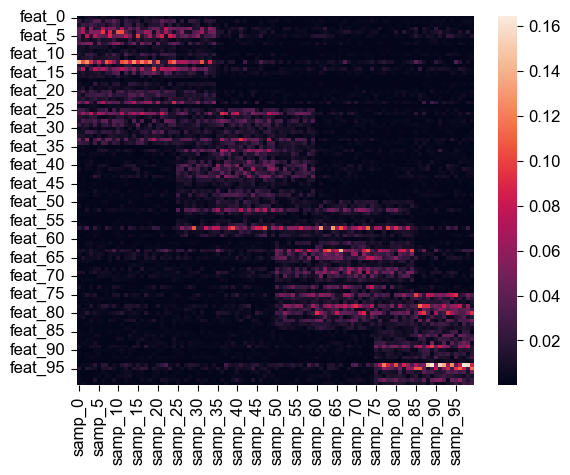

In [6]:
x = models.synthetic_data(
    overlap=0.4, 
    k=4, 
    scale_lognormal_params=dict(sigma=0.75)
)
# Each feature is assigned a weight drawn from a lognormal distribution, to roughly simulate some features (such a taxon) 
# generally taking higher values in input data.
sns.heatmap(x)

## Rank selection
The number of ranks $k$ is unknown, however we can attempt to estimate it using bi-crossvalidation. This tries learning a held out part of the data using the other parts for a range of ranks a large number of times, and we look at measures of how well the held out part was estimated to identify a suitable rank. These are run from largest rank to smallest, so the estimate of time tends to start of conservative.

In [7]:
rank_sel_res = rank_selection(x=x, ranks=range(2, 11), shuffles=20, seed=4298)
# shuffles sets the number iterations of bi-crossvalidation which are run. 
# The default is 100, it has been set lower here to make the documentation easier to compile, but 100 is a more 
# sensible value for real data

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:23<00:00,  7.53it/s]


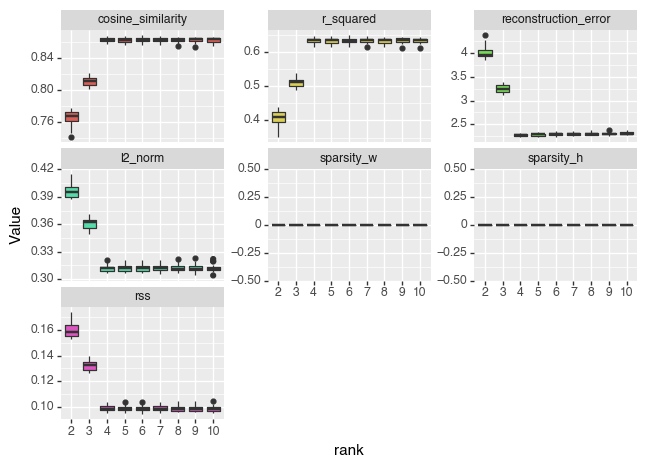

<Figure Size: (640 x 480)>

In [8]:
plot_rank_selection(rank_sel_res, jitter=False, n_col=3)

In these plots you are typically looking for elbow points; ranks after which the quality of the decomposition does not improve as rapidly, suggesting that adding more signatures is no longer contributing much explanatory power.

In our example, cosine similarity increases rapidly until $k=4$, and declines after this, indicating this is a suitable rank. Real world examples will rarely be so clear, and often several ranks will appear suitable.

The different measures here are:
* *Cosine Similarity*: Higher is better. The angle between the true data and estimated data, considering each as a flattened 1d vector
* *L2 Norm*: Euclidean distance between true and estimated data. Lower is better.
* *R-squared*: Coefficient of determination between true and estimated data. Higher is better.
* *Reconstruction Error*: Measure of the error in the estimated data compared to true. Lower is better.
* *Residual Sum of Sqaures*: Lower is better
* *Sparsity H*: Sparsity of the H matrix
* *Sparsity W*: Sparsity of the W matrix

When there are several candidate ranks, it is useful to generate decompositions for each and manually inspect them. This is usually the case, and some researcher judgement is required in eventually selecting which rank decomposition to use.

## Generating decompositions
For the ranks of interest, we can generate several decompositions to investigate. NMF solutions are non-unique and depend on the initialisation of the $H$ and $W$ matrices; some initialisations may give a better solution than others. One approach is to make many decompositions, and select those which optimise some criteria, such as reconstruction error.

Here we make 100 decompositions for each of ranks 3, 4, and 5, and keep only the top 5 for each rank. The result is a dictionary, with the key being the rank, and the value a list of Decompositions with the first being the best (lowest reconstruction error).

In [9]:
decomps = decompositions(x, ranks=[3, 4, 5], top_n=5, random_starts=100, seed=4928)
decomps

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 106.71it/s]


{3: [Decomposition[rank=3, beta_divergence=22.7],
  Decomposition[rank=3, beta_divergence=22.7],
  Decomposition[rank=3, beta_divergence=22.7],
  Decomposition[rank=3, beta_divergence=22.7],
  Decomposition[rank=3, beta_divergence=22.7]],
 4: [Decomposition[rank=4, beta_divergence=16.4],
  Decomposition[rank=4, beta_divergence=16.4],
  Decomposition[rank=4, beta_divergence=16.4],
  Decomposition[rank=4, beta_divergence=16.4],
  Decomposition[rank=4, beta_divergence=16.4]],
 5: [Decomposition[rank=5, beta_divergence=15.6],
  Decomposition[rank=5, beta_divergence=15.6],
  Decomposition[rank=5, beta_divergence=15.6],
  Decomposition[rank=5, beta_divergence=15.6],
  Decomposition[rank=5, beta_divergence=15.6]]}

We can inspect the decompositions using some inbuilt plotting functions

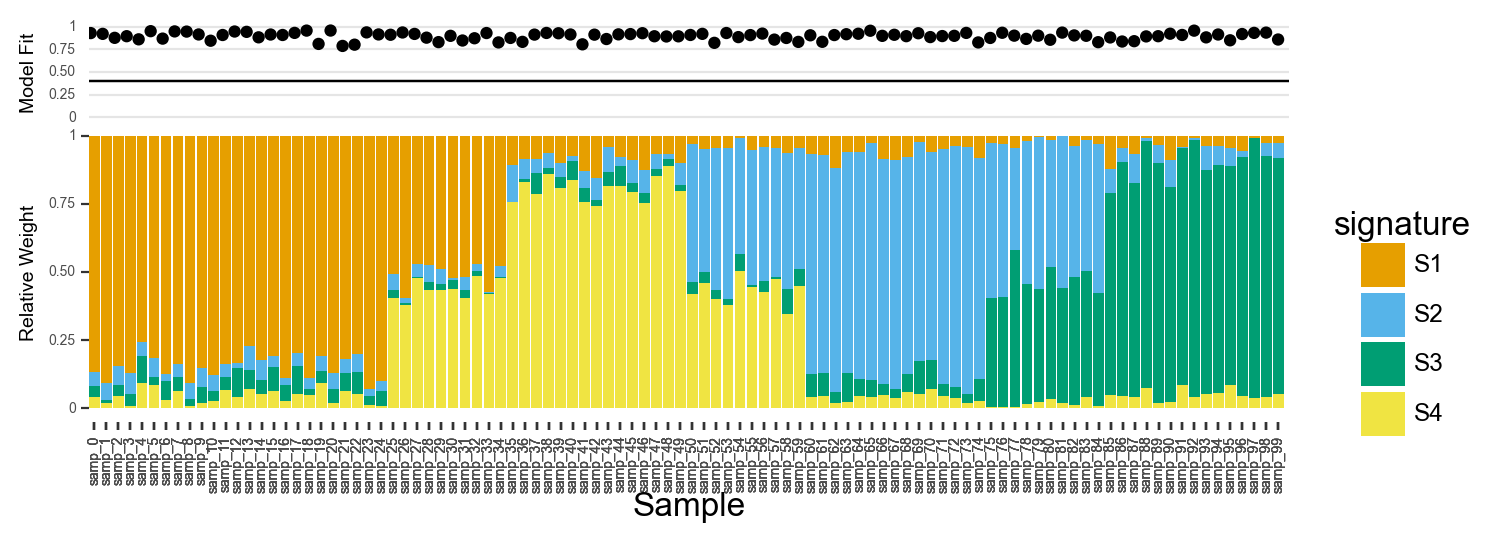

In [10]:
decomps[4][0].plot_relative_weight(heights=[0.5, 1.5])

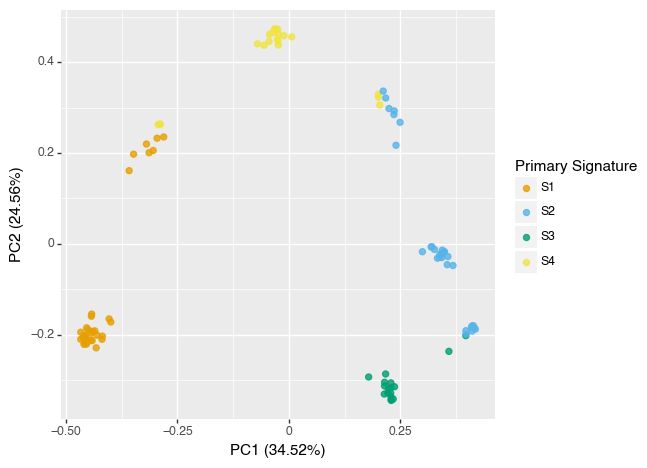

<Figure Size: (640 x 480)>

In [11]:
decomps[4][0].plot_pcoa()

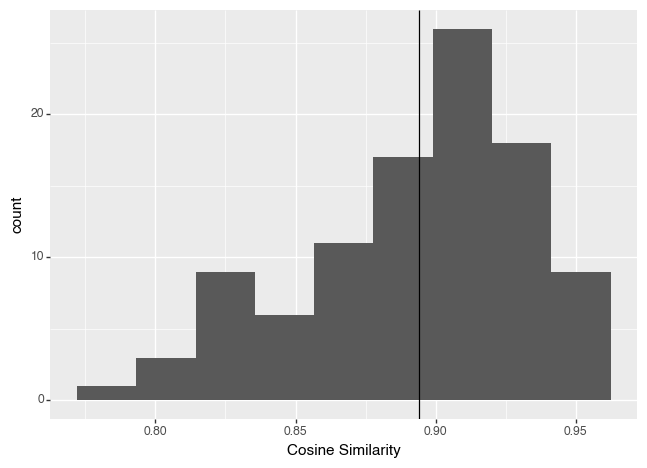

<Figure Size: (640 x 480)>

In [12]:
decomps[4][0].plot_modelfit()

## Slicing decompositions

We might be interested in visualising or analysis only a subset of a decomposition; perhaps we only want to look at one cohort of samples in a model, or only at some of the signatures. Decomposition objects can be indexed by sample, feature, and signature in that order. Normal slice syntax (1:5), lists of index names, or lists of index positions are supported. You can supply a mix of these.

This can also be used for abitrary reordering of samples and features for visualisations.

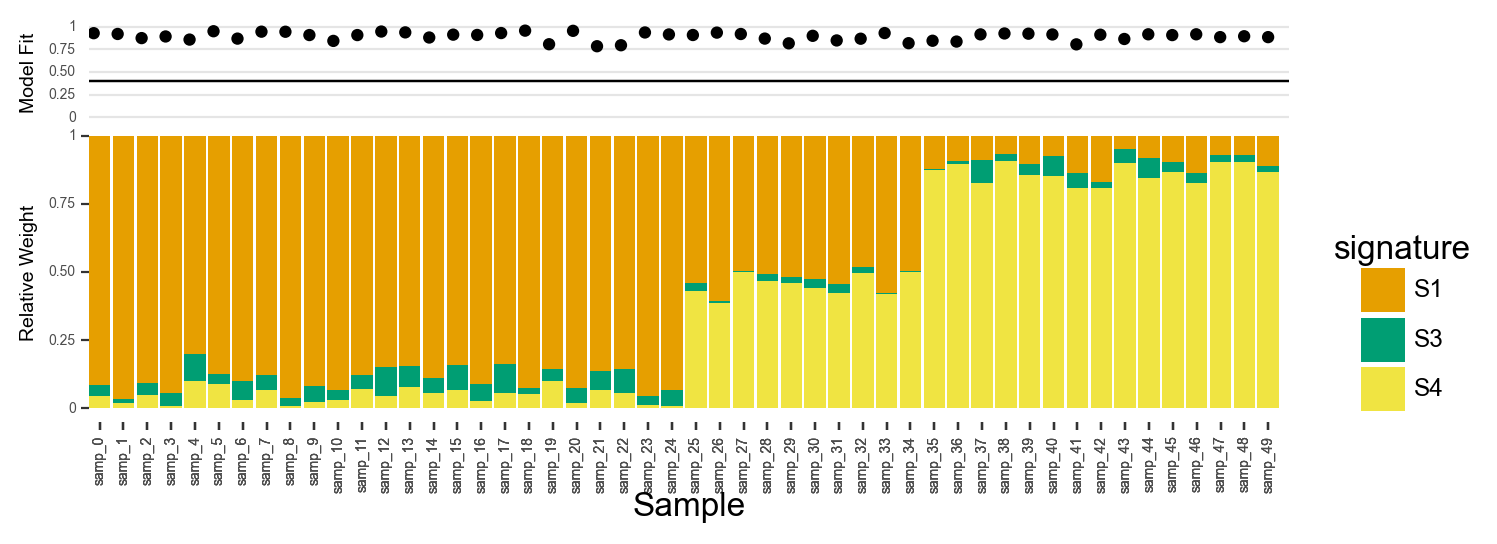

In [13]:
decomp_slcd = decomps[4][0][:50, :, ["S1", "S3", "S4"]]
decomp_slcd.plot_relative_weight(heights=[0.5, 1.5])

Here we have restricted to just the first 50 samples, and only signatures S1, S3 and S4. In the full decomposition, S2is important to described many samples from samp_30 to samp_49, so the model fit for these is much poorer in this reduced model.

Another potential use for the slicing syntax is to reorder samples based on some metadata condition. The method is illustrated below with a random reordering.

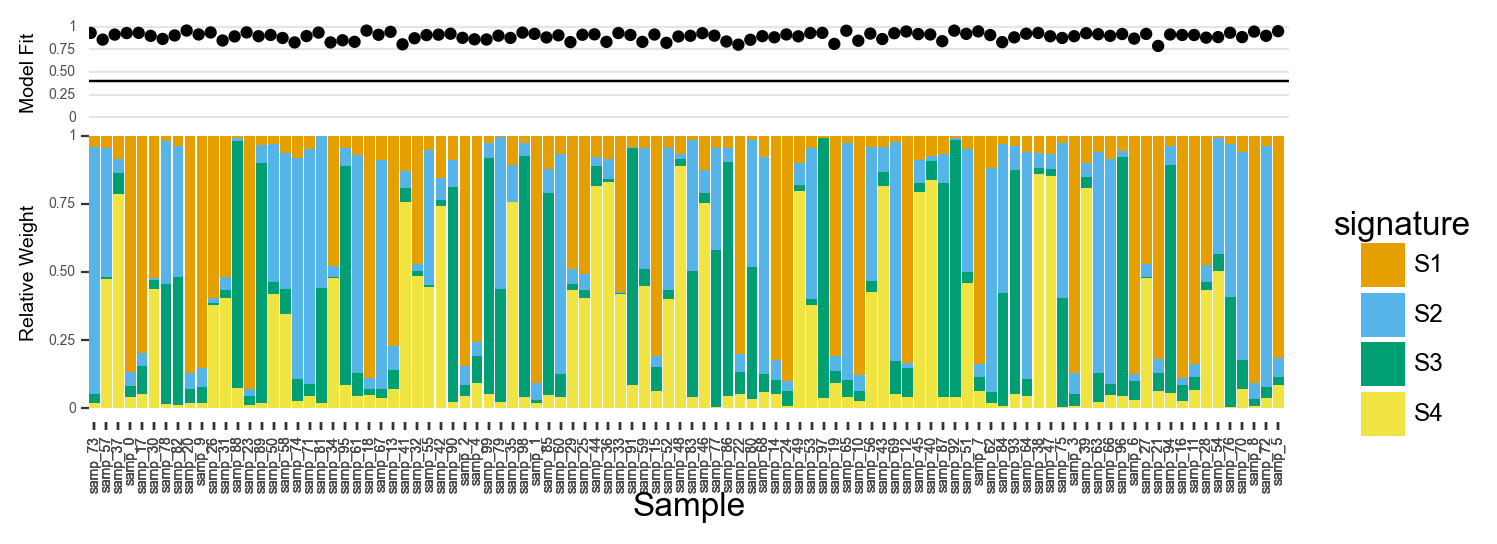

In [14]:
# Reorder samples - here we're just generating a random order
import random
new_order = list(range(decomps[4][0].h.shape[1]))
random.shuffle(new_order)

# Reorder the decomposition
decomps[4][0][new_order].plot_relative_weight(heights=[0.5, 1.5])

## Saving and loading
Decompositions can be saved to disk for analysis in other environments, or saved and reloaded later.

In [15]:
Decomposition.save_decompositions(decomps, output_dir=pathlib.Path("test_save"), symlink=False)

In [16]:
! ls test_save/**/**

test_save/3/0:
h.tsv                         plot_relative_weight.pdf
h_scaled.tsv                  primary_signature.tsv
model_fit.tsv                 properties.yaml
monodominant_samples.tsv      quality_series.tsv
parameters.yaml               representative_signatures.tsv
plot_feature_weight.pdf       w.tsv
plot_modelfit.pdf             w_scaled.tsv
plot_modelfit_point.pdf       x.tsv
plot_pcoa.pdf

test_save/3/1:
h.tsv                         plot_relative_weight.pdf
h_scaled.tsv                  primary_signature.tsv
model_fit.tsv                 properties.yaml
monodominant_samples.tsv      quality_series.tsv
parameters.yaml               representative_signatures.tsv
plot_feature_weight.pdf       w.tsv
plot_modelfit.pdf             w_scaled.tsv
plot_modelfit_point.pdf       x.tsv
plot_pcoa.pdf

test_save/3/2:
h.tsv                         plot_relative_weight.pdf
h_scaled.tsv                  primary_signature.tsv
model_fit.tsv                 properties.yaml
monodominant_sampl

These decompositions can be loaded from disk again

In [17]:
loaded_decomps = Decomposition.load_decompositions(in_dir=pathlib.Path("test_save"))
loaded_decomps

{3: [Decomposition[rank=3, beta_divergence=22.7],
  Decomposition[rank=3, beta_divergence=22.7],
  Decomposition[rank=3, beta_divergence=22.7],
  Decomposition[rank=3, beta_divergence=22.7],
  Decomposition[rank=3, beta_divergence=22.7]],
 4: [Decomposition[rank=4, beta_divergence=16.4],
  Decomposition[rank=4, beta_divergence=16.4],
  Decomposition[rank=4, beta_divergence=16.4],
  Decomposition[rank=4, beta_divergence=16.4],
  Decomposition[rank=4, beta_divergence=16.4]],
 5: [Decomposition[rank=5, beta_divergence=15.6],
  Decomposition[rank=5, beta_divergence=15.6],
  Decomposition[rank=5, beta_divergence=15.6],
  Decomposition[rank=5, beta_divergence=15.6],
  Decomposition[rank=5, beta_divergence=15.6]]}

An individual decomposition can also be loaded

In [18]:
one_decomp = Decomposition.load(in_dir=pathlib.Path("test_save/5/0/"))
one_decomp

Decomposition[rank=5, beta_divergence=15.6]

In [19]:
! rm -rf test_save